In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
inference_clip = json.loads(open(r"C:\Users\Gram\Desktop\NULP\uav_img_cap\bin\inference_verification_clip.json", "r").read())
inference_owl = json.loads(open(r"C:\Users\Gram\Desktop\NULP\uav_img_cap\bin\inference_verification_owlvit.json", "r").read())

In [8]:
inference_clip = pd.DataFrame(inference_clip)
inference_owl = pd.DataFrame(inference_owl)

In [83]:
inference_clip["probs"] = inference_clip.verification_clip_probs.apply(lambda named_probs: list(map(lambda x: x[1], named_probs)))
parsed_clip_by_object = inference_clip.explode(["probs", "objects"])[["image", "objects", "probs"]]

inference_owl["sum_of_prob_by_object"] = inference_owl.verification_clip_probs.apply(lambda clip_probs: list(map(lambda x: sum(x[1]), clip_probs)))
parsed_owl_by_object = inference_owl.explode(["sum_of_prob_by_object", "objects"], ignore_index=True)[["image", "objects", "sum_of_prob_by_object"]]


detection_by_object = parsed_clip_by_object.merge(parsed_owl_by_object, on=["image", "objects"], suffixes=("clip_", "owl_"))

In [111]:
detection_by_object["max_prob"] = detection_by_object[["probs", "sum_of_prob_by_object"]].max(axis=1)
detection_by_object.groupby("image")[["objects", "max_prob"]].apply(lambda r: dict(zip(r["objects"], r["max_prob"])))

image
/workspace/Russian-military-annotated-4/test/Amazon-51-_jpeg.rf.4cccd788d426246eb9498a6a7277c749.jpg    {'truck': 0.10599999874830246, 'bus': 0.003000...
/workspace/Russian-military-annotated-4/test/Target--4-_jpg.rf.970a83262313590cd92ecbc0faabaed2.jpg     {'semi-truck': 0.019999999552965164, 'Target l...
/workspace/Russian-military-annotated-4/test/null--35-_jpg.rf.22ad66c297ea7a691811d10748ef3220.jpg      {'man': 0.01900000066962093, 'bridge': 0.03500...
/workspace/Russian-military-annotated-4/test/null--40-_jpg.rf.c2fbc2239ad3be0cafd964b37f079462.jpg      {'military trucks': 0.9430000185966492, 'cars'...
/workspace/Russian-military-annotated-4/test/null--45-_jpg.rf.e6282c257d063ba61e6bbedc52795d95.jpg      {'truck': 0.4480000138282776, 'car': 0.0010000...
                                                                                                                              ...                        
/workspace/Russian-military-annotated-4/valid/null--50-_jpg.rf.1917554

In [150]:
import os
root = r"C:\Users\Gram\Desktop\NULP\uav_img_cap\notebooks\Russian-military-annotated-4"
sub_df = detection_by_object[detection_by_object["max_prob"] == 0].groupby("image")\
.apply(lambda sub_df: sub_df.iloc[0]).reset_index(drop=True).iloc[-10:]

sub_df = detection_by_object.nlargest(100, "max_prob").groupby("image").apply(lambda sub_df: sub_df.iloc[0]).reset_index(drop=True).iloc[-10:]
sub_df["local_path_to_image"] = sub_df.image.str.split("/").str[-2:].apply(lambda x: os.path.join(root, *x))
sub_df

,image,objects,probs,sum_of_prob_by_object,max_prob,local_path_to_image
84,/workspace/Russian-military-annotated-4/train/...,armored personnel carriers,1.000,0.007,1.000,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
85,/workspace/Russian-military-annotated-4/train/...,tank,1.000,0.006,1.000,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
86,/workspace/Russian-military-annotated-4/train/...,tanks,0.997,0.004,0.997,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
87,/workspace/Russian-military-annotated-4/train/...,tank,0.998,0.006,0.998,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
88,/workspace/Russian-military-annotated-4/train/...,armored vehicle,0.999,0.009,0.999,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
89,/workspace/Russian-military-annotated-4/train/...,tanks,0.998,0.008,0.998,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
90,/workspace/Russian-military-annotated-4/train/...,military vehicles,0.997,0.006,0.997,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
91,/workspace/Russian-military-annotated-4/train/...,tank,0.997,0.003,0.997,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
92,/workspace/Russian-military-annotated-4/train/...,UPS truck,1.000,0.003,1.000,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...
93,/workspace/Russian-military-annotated-4/train/...,UPS truck,1.000,0.014,1.000,C:\Users\Gram\Desktop\NULP\uav_img_cap\noteboo...


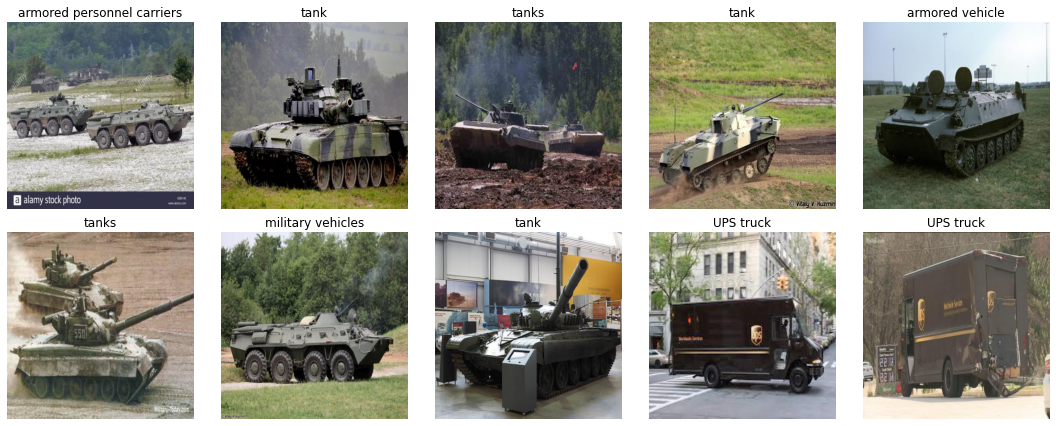

<Figure size 432x288 with 0 Axes>

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def plot_image_grid(df, image_col, label_col, title, grid_size=(2, 5), figsize=(15, 6)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(df):
            img = mpimg.imread(df.iloc[i][image_col])
            ax.imshow(img)
            ax.set_title(df.iloc[i][label_col])
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{title}.png", format='png', bbox_inches='tight')

plot_image_grid(sub_df, image_col="local_path_to_image", label_col="objects", grid_size=(2, 5), title="image_grid_high_prob_objects_by_object_detection_model")


In [63]:
# parsed_owl_by_object.objects.value_counts().reset_index()

,index,objects
0,tank,900
1,people,441
2,truck,404
3,person,396
4,trees,296
...,...,...
400,bumper,1
401,backpack bag,1
402,observers,1
403,remote control,1
